# Transformers for Classification
In this notebook we  willuse transformers to classify our disaster tweets.

Make sure this notebook is running on a GPU as this will speed up training. Click "Runtime" -> "Change Runtime Type" and make sure a GPU is selected as the Hardware accelerator.

First, lets make sure we have the right libraries installed:

In [1]:
!pip install torch transformers matplotlib tqdm pandas

## The Dataset 

[Kaggle Link](https://www.kaggle.com/c/nlp-getting-started/overview)

**Task Description:** Twitter has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [2]:
# !rm -rf disaster_tweets
# !mkdir -p disaster_tweets
# !wget https://github.com/ghomasHudson/text-mining-demos-workshop/raw/main/disaster_tweets.zip -O disaster_tweets/data.zip
# !unzip -j disaster_tweets/data.zip -d disaster_tweets
# !rm disaster_tweets/data.zip


In [3]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
import pandas as pd
import glob
import torch 
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)

/home/sean/Documents/NLP_Demonstration/demo_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PyTorch

PyTorch is a popular open-source machine learning framework that is primarily used for deep learning applications. It provides a flexible and dynamic computational graph, making it easy for researchers and developers to experiment with different neural network architectures.

First, we need to load some data. The simple transformers library expects data in a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), so lets use pandas to load a csv file.

The following cell downloads a csv file from the web:

Now lets load it into a pandas dataframe:

In [4]:
train_df = pd.read_csv("disaster_tweets/train.csv")

# Create the evaluation set
eval_df = train_df.sample(frac=0.3, random_state=42)
train_df = train_df.drop(eval_df.index)

test_df = pd.read_csv("disaster_tweets/test.csv")

train_df.head()

,id,keyword,location,text,target
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1


We already have the tweets in the "text" column so simply rename "target" to "labels":

In [5]:
train_df = train_df.rename(columns={"target": "labels"})
eval_df = eval_df.rename(columns={"target": "labels"})
test_df = test_df.rename(columns={"target": "labels"})

train_df.head()

,id,keyword,location,text,labels
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1


## Tokenization

The object of tokenization is to break input sentences down into individual tokens. These tokens can be words, characters, or subwords, depending on the specific tokenization technique used.

BERT leverages a WordPiece tokenization approach. This technique handles out-of-vocabulary words by breaking them down into smaller subword units. 

E.g. "Mitochondria" is tokenized as ['mit', '##och', '##ond', '##ria']. This approach allows BERT to handle a wide range of words, including rare or unseen ones.

We also convert words to their dictionary IDs and pad or truncate them to the same max length.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text = "Hello, this one sentence!"
    
print(f'Original: {text}')
    
print(f'Tokens: {tokenizer.tokenize(text)}')
print(f'Encoded: {tokenizer.encode(text)}')
print(f'Decoded: {tokenizer.decode(tokenizer.encode(text))}')
print(f"Padded: {tokenizer.encode(text, max_length=128, pad_to_max_length=True, truncation=True)}")
print(f"Shape: {len(tokenizer.encode(text, max_length=128, pad_to_max_length=True, truncation=True))}")

Original: Hello, this one sentence!
Tokens: ['hello', ',', 'this', 'one', 'sentence', '!']
Encoded: [101, 7592, 1010, 2023, 2028, 6251, 999, 102]
Decoded: [CLS] hello, this one sentence! [SEP]
Padded: [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Shape: 128


/home/sean/Documents/NLP_Demonstration/demo_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row.text
        label = row.labels

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }
        
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_dataset = DisasterTweetsDataset(train_df, tokenizer)
eval_dataset = DisasterTweetsDataset(eval_df, tokenizer)
test_dataset = DisasterTweetsDataset(test_df, tokenizer)

## BERT Model

We will now create our BERT model using the 'AutoModel' class from HuggingFace. This will download the pretrained weights of BERT and initialise it. We then apply a 10% dropout before applying a linear layer with an input size of the output dimension of the BERT model's pooled output and an output size equal to the number of labels in our classification (in this case 2)

HuggingFace Model Link: [FacebookAI/roberta-base](https://huggingface.co/FacebookAI/roberta-base)


In [8]:
class BERT(torch.nn.Module):
    def __init__(self, pretrained_model, num_labels=None):
        super(BERT, self).__init__()
        self.num_labels = num_labels
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels) if num_labels else None

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        if self.num_labels:  # For classification
            output = self.classifier(output)
        return output

## Word Embeddings

Word embeddings is what actually comes out of a LLM like BERT. The only difference between BERT as a classification model and BERT as an embedding model is the final linear layer, where we map the embeddings to the number of labels (i.e. 768 dimensions -> 2 dimensions (or labels))

Below, we have disabled the classifier layer of the above model by not passing in the num_labels paramter. In this example, the embeddings from BERT given the sentences are returned

In [9]:
def get_embeddings(sentence):
    model = BERT(pretrained_model='bert-base-uncased').to(device)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    with torch.no_grad():
        model.eval()
        sentence = tokenizer(
            sentence, max_length=128, padding=True, truncation=True,  return_tensors="pt",
        ).to(device)
        outputs = model(
            input_ids=sentence["input_ids"], attention_mask=sentence["attention_mask"]
        )
        return outputs


def get_similarity(embedding_1, embedding_2):
    embedding_1 = torch.nn.functional.normalize(embedding_1, p=2, dim=1)
    embedding_2 = torch.nn.functional.normalize(embedding_2, p=2, dim=1)
    cos = torch.nn.CosineSimilarity(dim=1)
    return cos(embedding_1, embedding_2).item()


example_1 = "Labrador Retriever"
example_2 = "Cocker Spaniel"
example_3 = "Cat"

print(
    f"\n{example_1} vs {example_2} == {get_similarity(get_embeddings(example_1), get_embeddings(example_2))}"
)
print(
    f"\n{example_1} vs {example_3} == {get_similarity(get_embeddings(example_1), get_embeddings(example_3))}"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Labrador Retriever vs Cocker Spaniel == 0.9898459315299988


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationsh


Labrador Retriever vs Cat == 0.6475598812103271


## Training Loop

We will now train our BERT model on the disaster tweets dataset. Training on a T4 GPU takes approximately 2 minutes per epoch. The training loop will handle the forward pass, loss computation, backward pass, and optimization steps.

Some weights of the model checkpoint at FacebookAI/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating

Epoch 1/10 - Train Loss: 0.6764            Train Accuracy: 0.5884, Eval Loss: 0.6513            Eval Accuracy: 0.6480



Evaluating Epoch 2: 100%|██████████| 141/141 [00:04<00:00, 32.56it/s]


Epoch 2/10 - Train Loss: 0.5256            Train Accuracy: 0.7538, Eval Loss: 0.4051            Eval Accuracy: 0.8373



Evaluating Epoch 3: 100%|██████████| 141/141 [00:04<00:00, 32.67it/s]


Epoch 3/10 - Train Loss: 0.4102            Train Accuracy: 0.8261, Eval Loss: 0.3847            Eval Accuracy: 0.8449



Evaluating Epoch 4: 100%|██████████| 141/141 [00:04<00:00, 32.65it/s]


Epoch 4/10 - Train Loss: 0.3846            Train Accuracy: 0.8389, Eval Loss: 0.3837            Eval Accuracy: 0.8409



Evaluating Epoch 5: 100%|██████████| 141/141 [00:04<00:00, 32.61it/s]


Epoch 5/10 - Train Loss: 0.3736            Train Accuracy: 0.8436, Eval Loss: 0.3748            Eval Accuracy: 0.8488



Evaluating Epoch 6: 100%|██████████| 141/141 [00:04<00:00, 32.65it/s]


Epoch 6/10 - Train Loss: 0.3609            Train Accuracy: 0.8467, Eval Loss: 0.3769            Eval Accuracy: 0.8475



Evaluating Epoch 7: 100%|██████████| 141/141 [00:04<00:00, 32.64it/s]


Epoch 7/10 - Train Loss: 0.3435            Train Accuracy: 0.8577, Eval Loss: 0.3845            Eval Accuracy: 0.8457



Evaluating Epoch 8: 100%|██████████| 141/141 [00:04<00:00, 32.69it/s]


Epoch 8/10 - Train Loss: 0.3338            Train Accuracy: 0.8649, Eval Loss: 0.3804            Eval Accuracy: 0.8493



Evaluating Epoch 9: 100%|██████████| 141/141 [00:04<00:00, 32.72it/s]


Epoch 9/10 - Train Loss: 0.3236            Train Accuracy: 0.8672, Eval Loss: 0.3853            Eval Accuracy: 0.8511



Evaluating Epoch 10: 100%|██████████| 141/141 [00:04<00:00, 32.74it/s]


Epoch 10/10 - Train Loss: 0.3100            Train Accuracy: 0.8733, Eval Loss: 0.3958            Eval Accuracy: 0.8449



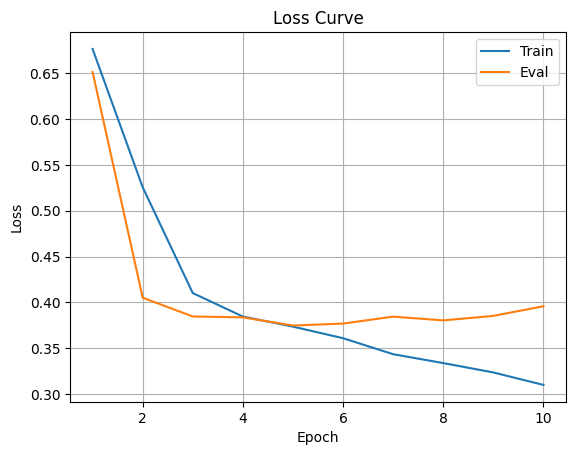

In [20]:
def loss_plot(epochs, train_loss, eval_loss):
  """
  Plots the training and evaluation loss over epochs.
  """
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, eval_loss, label="Eval")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()
  plt.grid(True)
  plt.show()


def train_model(
    train_dataset,
    eval_dataset,
    model,
    criterion,
    optimizer,
    num_epochs,
    batch_size,
    device,
    save_dir,
):
    # Load existing model if available
    model_paths = glob.glob(f"{save_dir}/*.pth")
    if model_paths:
        print(f"Loading model from {model_paths[0]}...")
        model.load_state_dict(torch.load(model_paths[0], map_location=device))
        return model
    else:
        os.makedirs(save_dir, exist_ok=True)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    loss_vals = {"epoch": [], "train": [], "eval": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        with torch.set_grad_enabled(True):
            for batch in tqdm(train_loader, desc=f"Training  Epoch  {epoch+1}"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)

                train_accuracy = train_correct / train_total
                avg_train_loss = train_loss / len(train_loader)

        eval_loss = 0
        eval_correct = 0
        eval_total = 0

        with torch.no_grad():
            model.eval()
            for batch in tqdm(eval_loader, desc=f"Evaluating Epoch {epoch+1}"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)  # Use same criterion as training

                eval_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                eval_correct += (predicted == labels).sum().item()
                eval_total += labels.size(0)

                eval_accuracy = eval_correct / eval_total
                avg_eval_loss = eval_loss / len(eval_loader)

        loss_vals["train"].append(avg_train_loss)
        loss_vals["eval"].append(avg_eval_loss)
        loss_vals["epoch"].append(epoch + 1)
        print(
            f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}\
            Train Accuracy: {train_accuracy:.4f}, Eval Loss: {avg_eval_loss:.4f}\
            Eval Accuracy: {eval_accuracy:.4f}\n"
        )
    # Plotting loss
    loss_plot(loss_vals['epoch'], loss_vals["train"], loss_vals["eval"])

    # Save model
    torch.save(model.state_dict(), f"{save_dir}/model.pth")

    return model

model = BERT(pretrained_model=model_name, num_labels=2)
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-7)


classifier_model = train_model(
    train_dataset,
    eval_dataset,
    model=model,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=10,
    batch_size=16,
    device=device,
    save_dir="cache/",
)

In [11]:
def inference(model, dataset, device):
    dataloader = DataLoader(dataset, batch_size=8)
    model.eval()

    predictions = []
    ground_truth = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    return predictions, ground_truth

predictions, ground_truth = inference(classifier_model, test_dataset, device)
report = classification_report(ground_truth, predictions, target_names=["Not Disaster", "Disaster"], output_dict=True)
pd.DataFrame(report).T

100%|██████████| 12/12 [00:00<00:00, 63.74it/s]


,precision,recall,f1-score,support
Not Disaster,0.906977,1.000000,0.951220,39.000000
Disaster,1.000000,0.927273,0.962264,55.000000
accuracy,0.957447,0.957447,0.957447,0.957447
macro avg,0.953488,0.963636,0.956742,94.000000
weighted avg,0.961405,0.957447,0.957682,94.000000


# Additional Exercises

1. Experiment with different training parameter values. Can you improve the performance? 
2. Try using a pretrained model: [hkayesh/twitter-disaster-nlp](https://huggingface.co/hkayesh/twitter-disaster-nlp?text=The+woods+are+on+fire)
3. Try other datasets. Either your own or one from the [Huggingface Hub](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=trending).
  A good choice is the [Twitter financial news sentiment](https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment) dataset. Work out how to download it and convert to the format required for simple transformers.
4. Experiment with other transformer models

If you want a dataset to experiment with, you might wanna try the yelp product review dataset:

In [12]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz -O yelp_data/data.tgz
# !tar -xvzf yelp_data/data.tgz -C data/
# !mv yelp_data/yelp_review_polarity_csv/* yelp_data/
# !rm -r yelp_data/yelp_review_polarity_csv/
# !rm yelp_data/data.tgz

Be careful with the labels for this dataset. Heres some code to do that for you:

In [13]:
train_df = pd.read_csv("data/train.csv", header=None)
eval_df = pd.read_csv("data/test.csv", header=None)

train_df.head()

,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


First, notice that the label column has values 1 and 2. We need them to be 0,1 for binary classification. Lets fix that:

In [14]:
train_df[0] = (train_df[0] == 2).astype(int)
eval_df[0] = (eval_df[0] == 2).astype(int)

train_df.head()

,0,1
0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...


*Now* lets rename the columns to be "text" and "label" alongside removing line breaks:

In [15]:
train_df = pd.DataFrame(
      {"text": train_df[1].replace(r"\n", " ", regex=True), "labels": train_df[0]}
)

eval_df = pd.DataFrame(
      {"text": eval_df[1].replace(r"\n", " ", regex=True), "labels": eval_df[0]}
)
train_df.head()

,text,labels
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


It will take a long time for the model to train with such a large dataset so you might want to cut it down a little:

In [16]:
train_df = train_df.head(4000)
eval_df = eval_df.head(100)